In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

from skimage import io, transform
from tensorflow.keras.utils import to_categorical
import time
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#path to images
img_dir = "../input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset/Training_data/"



#list all available images type
print(os.listdir(img_dir))



/kaggle/input
/kaggle/input/selfieimagedetectiondataset
/kaggle/input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset
/kaggle/input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset/Validation_data
/kaggle/input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie
/kaggle/input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset/Validation_data/Selfie
/kaggle/input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset/Training_data
/kaggle/input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset/Training_data/NonSelfie
/kaggle/input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset/Training_data/Selfie
/kaggle/input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset/Test_data
/kaggle/input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset/Test_data/NonSelfie
/kaggle/input/selfieimagedetectiondataset/Selfie-Image-Detection-Dataset/Test_data/Selfie
/kaggle/input/pretrainedmodel
['NonSelfie',

In [2]:
def load_data(img_dir):
    X = []
    y = []
    labels = []
    idx = 0
    for i,folder_name in enumerate(os.listdir(img_dir)):
        if folder_name in ('NonSelfie', 'Selfie'):
            labels.append(folder_name)
            for file_name in tqdm(os.listdir(f'{img_dir}/{folder_name}')):
                if file_name.endswith('jpg'):
                    im = cv2.imread(f'{img_dir}/{folder_name}/{file_name}')
                    if im is not None:
                        #For Right RGB Colors
                        # img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                        im = cv2.resize(im, (120, 120))
                        X.append(im)
                        y.append([idx])
            idx+=1
        
    X = np.asarray(X)
    y = np.asarray(y)
    labels = np.asarray(labels)
    return X,y,labels

X,y,labels = load_data(img_dir)
print(labels)

100%|██████████| 38974/38974 [04:15<00:00, 152.81it/s]


['NonSelfie' 'Selfie']


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
train_img = X_train
train_labels = y_train
test_img = X_test
test_labels = y_test
train_img.shape, train_labels.shape, test_img.shape, test_labels.shape

((53460, 120, 120, 3), (53460, 1), (9435, 120, 120, 3), (9435, 1))

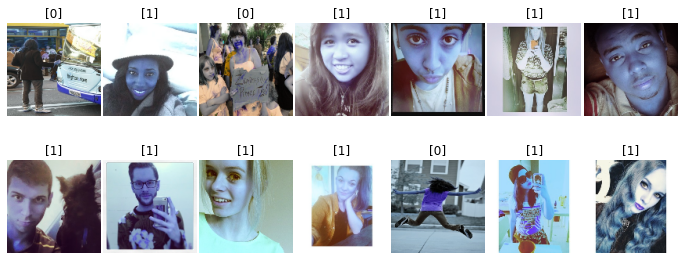

In [4]:
#show random samples
rand_14 = np.random.randint(0, train_img.shape[0],14)
sample_img = train_img[rand_14]
sample_labels = train_labels[rand_14]
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),gridspec_kw={'wspace':0.03, 'hspace':0.01})
for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_img[image_index])
        ax[r,c].set_title('%s' % sample_labels[image_index])
plt.show()
plt.close()

In [5]:
#one-hot-encode the labels
num_classes = len(labels)
train_labels_selfie = to_categorical(train_labels,num_classes)
test_labels_selfie = to_categorical(test_labels,num_classes)
train_labels_selfie.shape, test_labels_selfie.shape

((53460, 2), (9435, 2))

In [6]:
train_data = train_img
test_data = test_img
train_data.shape, test_data.shape

((53460, 120, 120, 3), (9435, 120, 120, 3))

In [7]:
# shuffle the training dataset & set aside val_perc % of rows as validation data
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

# randomly sorted!
train_data = train_data[indexes]
train_labels_selfie = train_labels_selfie[indexes]

# now we will set-aside val_perc% of the train_data/labels as cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))
print(val_count)

# first pick validation set
val_data = train_data[:val_count,:]
val_labels_selfie = train_labels_selfie[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_selfie2 = train_labels_selfie[val_count:,:]

train_data2.shape, train_labels_selfie2.shape, val_data.shape, val_labels_selfie.shape, test_data.shape, test_labels_selfie.shape

5346


((48114, 120, 120, 3),
 (48114, 2),
 (5346, 120, 120, 3),
 (5346, 2),
 (9435, 120, 120, 3),
 (9435, 2))

In [8]:
print(val_labels_selfie)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [9]:
# a utility function that plots the losses and accuracies for training & validation sets across our epochs
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']
    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals


In [10]:
def print_time_taken(start_time, end_time):
    secs_elapsed = end_time - start_time
    
    SECS_PER_MIN = 60
    SECS_PER_HR  = 60 * SECS_PER_MIN
    
    hrs_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_HR)
    mins_elapsed, secs_elapsed = divmod(secs_elapsed, SECS_PER_MIN)
    
    if hrs_elapsed > 0:
        print('Time taken: %d hrs %d mins %d secs' % (hrs_elapsed, mins_elapsed, secs_elapsed))
    elif mins_elapsed > 0:
        print('Time taken: %d mins %d secs' % (mins_elapsed, secs_elapsed))
    elif secs_elapsed > 1:
        print('Time taken: %d secs' % (secs_elapsed))
    else:
        print('Time taken - less than 1 sec')

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Activation,MaxPooling2D

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import LearningRateScheduler

from keras.models import load_model

from sklearn.model_selection import train_test_split

from PIL import Image

import numpy as np
from keras.utils import np_utils

from keras.utils.np_utils import to_categorical

In [12]:
# Demo data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [13]:
#create multiple cnn model for ensembling
#model 1
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (120, 120, 3)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# model.add(Conv2D(512, kernel_size = 3, activation='relu'))
# model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# model.add(Conv2D(1024, kernel_size = 3, activation='relu'))
# model.add(BatchNormalization())
model.add(Conv2D(1024, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 118, 118, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 116, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 116, 116, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 58, 58, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 58, 58, 32)        0

In [ ]:
# after each epoch decrease learning rate by 0.95
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# train
epochs = 10
j=0
start_time = time.time()
history = model.fit(datagen.flow(train_data2, train_labels_selfie2, batch_size=64),epochs = epochs, 
                    steps_per_epoch = train_data2.shape[0]/64,
                    validation_data = (val_data, val_labels_selfie), 
                    callbacks=[annealer], verbose=1)
end_time = time.time()
print_time_taken(start_time, end_time)


print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}"
      .format(j+1,epochs,history.history['accuracy'][epochs-1],
              history.history['val_accuracy'][epochs-1]))

Epoch 1/10
496/751 [==================>...........] - ETA: 17:54 - loss: 0.4055 - accuracy: 0.8582

In [ ]:
from keras.models import model_from_json
f = open("/kaggle/input/pretrainedmodel/model_cnn2.json",'r')
json_string = f.read()
f.close()
model = model_from_json(json_string)
model.load_weights('/kaggle/input/pretrainedmodel/model_cnn2.h5')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


train_loss, train_accuracy = model.evaluate(train_data2, train_labels_selfie2, batch_size=64)
print('Train loss: %.4f accuracy: %.4f' % (train_loss, train_accuracy))
test_loss, test_accuracy = model.evaluate(test_data, test_labels_selfie, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

In [ ]:
from sklearn.metrics import confusion_matrix 
test_preds = model.predict(test_data) 
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == test_labels_selfie)[0]) 
print("Correct predictions:", correct_predictions) 
print("Total number of test examples:", len(test_labels_selfie))
print("Accuracy of Test Model: ", correct_predictions/float(len(test_labels_selfie)))

x_pred = test_preds.argmax(1) 
y_test_s = test_labels_selfie.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest') 
plt.title('Confusion matrix - model')
plt.colorbar() 
plt.ylabel('expected label') 
plt.xlabel('predicted label') 
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("model_cnn2.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model_cnn2.h5")
model.save("model_cnn2.h5")